## Introduction

The experimental data shows a strong hysteresis in the capillary pressure defined as $P_c = P_{water} - P_{air}$. Whereby, on injecting water into an air-filled GDL, positive capillary pressure is required, whereas negative capillary pressure is required to withdraw the water. This signifies that the material is neither wetting to water nor air and was previously explained by contact angle hysteresis. However, by considering the shape of the interface as it moves in-between fibers a more logical explanation can be found. The constrictions between fibers are modelled as toroidal or donut shaped, as first explained by [Purcell](https://www.onepetro.org/journal-paper/SPE-950369-G). With changing capillary pressure, as the mensicus contact line moves it conforms to the converging and diverging geometry and this modifies the effective contact angle. An inflection always occurs, irrespective of the intrinsic contact angle, signifying a change in pressure from negative to positive in the invading phase.

The invasion mechanism in highly porous fibrous media is complex and considering invasion of a single throat in isolation is not appropriate. The entry pressure in the simple isolated case is just the maximum pressure experienced by the meniscus as it transitions through the throat: termed burst pressure. However, the model allows for the bulge of the mensiscus to protrude quite far into the neighboring pore before the burst pressure is exceeded. The model is used in a new ```meniscus``` class of OpenPNM which supplies information about the position, size and shape of the mensicus at a given capillary pressure. These details are used by the ```MixedInvasionPercolation``` class to determine which type of invasion event may occur as it is now possible to determine whether an individual meniscus inside a throat will interact with solid features in neighboring pores (touch pressure) or even neighboring meniscii (cooperative pore filling). As nearby mensicii may grow simulataneously, they may coalesce at much lower pressure than the burst pressure, thus changing the characteristic capillary behaviour and saturation profile within the material. 

The network is generated using the ```VoronoiFibers``` class, for which there is a tutorial in the topology folder. For speed and convenience we provide a pickled dictionary with the network properties because the domain is quite large and would take 30 mins to generate from scratch.

# Major Steps

## Generate the network

- Go to folder : in openpnm 3 / examples / tutorials / 02_network_generation_and_visualization.ipynb 

## Assign geometric properties 

-  Go to folder : in openpnm 3 / exemples / tutorials / 05_defining_geometry.ipynb

## Simulating transport

- Go to folder : in openpnm 3 / exemples / tutorials / 08_simulating_transport.ipynb

##  Visualization 

- Go to folder openpnm 3 / exemples / tutorials / 10_visualization_options.ipynb

# Reproducing Tranter paper

## Model Setup
First we import the required python modules 

In [1]:
import pickle as pk
import numpy as np
import openpnm as op
import porespy as ps
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
from openpnm.models import physics as pm
%matplotlib inline
ws = op.Workspace()
ws.settings["loglevel"] = 50
ws.clear()
np.random.seed(10)

## Generate Random Network: Delaunay and Voronoi Tessellations

### openpnm2.8.2 -> run jupyter in env with openmm 2.8.2 

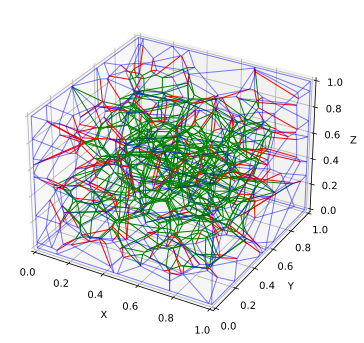

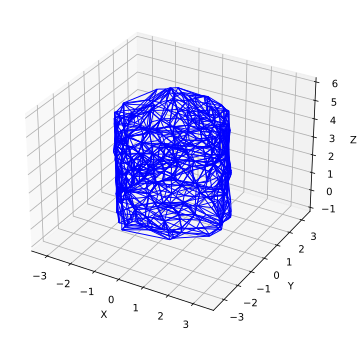

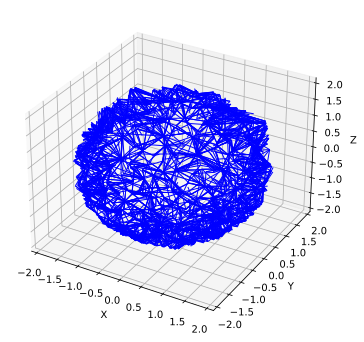

In [2]:
# cubic

cube = op.network.DelaunayVoronoiDual(num_points=200, shape=[1, 1, 1])

fig, ax = plt.subplots()
Ts = cube.throats(['voronoi', 'boundary'], mode='and')
op.topotools.plot_connections(network=cube, throats=Ts, alpha=0.5, ax=ax)
Ts = cube.throats(['voronoi', 'internal'], mode='and')
op.topotools.plot_connections(network=cube, throats=Ts, c='g', ax=ax)
Ts = cube.throats(['voronoi', 'surface'], mode='and')
op.topotools.plot_connections(network=cube, throats=Ts, c='r', ax=ax)


# Cylinder

cyl = op.network.DelaunayVoronoiDual(num_points=200, shape=[2, 5])
op.topotools.plot_connections(network = cyl, throats=cyl.throats('boundary'))

# spherical

sph = op.network.DelaunayVoronoiDual(num_points=500, shape=[2])
op.topotools.plot_connections(network = sph, throats=sph.throats('surface'))

## Assigning geometrical properties to the random network : Pore size and throat size 

the pore centers randomly distributed in space it becomes challenging to know what pore size to assign to each location.  Assigning pores that are too large results in overlaps, which makes it impossible to properly account for porosity and transport lengths.  OpenPNM includes a Geometry model called ```largest_sphere``` that solves this problem.  Let's assign the largest possible pore size to each Voronoi node in the network

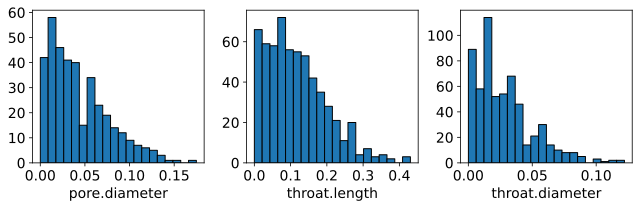

In [3]:
## Generate the network

pn = op.network.DelaunayVoronoiDual(num_points=200, shape=[1, 1, 1])

## Assign geometric properties

Ts = pn.throats(['voronoi', 'boundary'], mode='and')
Ps = pn.pores(['voronoi', 'boundary'], mode='and')

geom = op.geometry.GenericGeometry(network=pn, pores=Ps, throats=Ts)

mod = op.models.geometry.pore_size.largest_sphere
geom.add_model(propname='pore.diameter', model=mod)
mod = op.models.geometry.throat_length.ctc
geom.add_model(propname='throat.length', model=mod)
mod = op.models.geometry.throat_size.from_neighbor_pores
geom.add_model(propname='throat.diameter', model=mod)
geom.show_hist(['pore.diameter', 'throat.length', 'throat.diameter'])
mod = op.models.geometry.pore_volume.sphere
geom.add_model(propname='pore.volume',
              model=mod)
mod = op.models.geometry.throat_volume.cylinder
geom.add_model(propname='throat.volume',
              model=mod)

"""
geo['throat.conduit_lengths.pore1']= geo['throat.length']
geo['throat.conduit_lengths.pore2']= geo['throat.length']

geo.add_model(propname='pore.area',
              model=mods.geometry.pore_cross_sectional_area.sphere)
geo.add_model(propname='pore.volume',
              model=mods.geometry.pore_volume.sphere)

geo.add_model(propname='throat.endpoints',
              model=mods.geometry.throat_endpoints.spherical_pores)
geo.add_model(propname='throat.volume',
              model=mods.geometry.throat_volume.cylinder)
geo.add_model(propname='throat.area',
              model=mods.geometry.throat_cross_sectional_area.cylinder)

geo.add_model(propname='throat.surface_area',
              model=mods.geometry.throat_surface_area.cylinder)
geo.add_model(propname='throat.endpoints',
              model=mods.geometry.throat_endpoints.spherical_pores)
geo.add_model(propname='throat.conduit_lengths',
              model=mods.geometry.throat_length.conduit_lengths)
"""

## Label boundaries


pn = ps.networks.label_boundaries(pn,labels=[['left', 'right'], ['front', 'back'], [ 'bottom','top']], tol=1e-9)


Now we set some key variables for the simulation, $\theta$ is the contact angle in each phase and without contact hysteresis sums to 180. The fiber radius is 5 $\mu m$ for this particular material and this used in the pore-scale capillary pressure models.

In [4]:
theta_w = 110
theta_a = 70
fiber_rad = 5e-6

## Phase setup : Temperature, surface tension, contact angle

Now we set up the phases and apply the contact angles.

In [5]:
air = op.phases.Air(network=pn, name='air')
water = op.phases.Water(network=pn, name='water')
air['pore.contact_angle'] = theta_a
air["pore.surface_tension"] = water["pore.surface_tension"]
water['pore.contact_angle'] = theta_w
water["pore.temperature"] = 293.7
water.regenerate_models()

## Physics Setup

Now we set up the physics for each phase. The default capillary pressure model from the ```Standard physics``` class is the Washburn model which applies to straight capillary tubes and we must override it here with the Purcell model. We add the model to both phases and also add a value for pore.entry_pressure making sure that it is less than any of the throat.entry_pressure values. This is done because the ```MixedInvasionPercolation``` model invades pores and throats separately and for now we just want to consider the pores to be invaded as soon as their connecting throats are.

In [6]:
phys_air = op.physics.Standard(network=pn, phase=air, geometry=geom, name='phys_air')
phys_water = op.physics.Standard(network=pn, phase=water, geometry=geom, name='phys_water')
throat_diam = 'throat.diameter'
pore_diam = 'pore.indiameter'

pmod = pm.capillary_pressure.purcell
phys_water.add_model(propname='throat.entry_pressure',
                     model=pmod,
                     r_toroid=fiber_rad,
                     diameter=throat_diam)
phys_air.add_model(propname='throat.entry_pressure',
                   model=pmod,
                   r_toroid=fiber_rad,
                   diameter=throat_diam)

# Ignore the pore entry pressures
phys_air['pore.entry_pressure'] = -999999
phys_water['pore.entry_pressure'] = -999999

print("Mean Water Throat Pc:", "{0:.4E}".format(np.mean(phys_water["throat.entry_pressure"])))
print("Mean Air Throat Pc:", "{0:.4E}".format(np.mean(phys_air["throat.entry_pressure"])))

Mean Water Throat Pc: 7.4030E+01
Mean Air Throat Pc: 6.8456E+01


We apply the following late pore filling model:
$ S_{res} = S_{wp}^*\left(\frac{P_c^*}{P_c}\right)^{\eta}$
This is a heuristic model that adjusts the phase ocupancy inside an individual after is has been invaded and reproduces the gradual expansion of the phases into smaller sub-pore scale features such as cracks fiber intersections.

In [7]:
lpf = 'pore.late_filling'
phys_water.add_model(propname='pore.pc_star',
                     model=op.models.misc.from_neighbor_throats,
                     prop='throat.entry_pressure',
                     mode='min')
phys_water.add_model(propname=lpf,
                     model=pm.multiphase.late_filling,
                     pressure='pore.pressure',
                     Pc_star='pore.pc_star',
                     Swp_star=0.25,
                     eta=2.5)

## Throat meniscus

In [8]:
phys_air.add_model(propname='throat.meniscus',
                   model=op.models.physics.meniscus.purcell,
                   mode='men',
                   #r_toroid=fiber_rad,
                   target_Pc=5000)

ValueError: operands could not be broadcast together with shapes (1900,9093) (599,) (1900,9093) 

## Percolation Algorithms

Now all the physics is defined we can setup and run two algorithms for water injection and withdrawal and compare to the experimental data.

**NOTE:** THIS NEXT STEP MIGHT TAKE SEVERAL MINUTES.

In [8]:
inv_points = np.arange(-15000, 15100, 10)

IP_injection = op.algorithms.MixedInvasionPercolation(network=pn, name='injection')
IP_injection.setup(phase=water)
IP_injection.set_inlets(pores=pn.pores('bottom'))
IP_injection.settings['late_pore_filling'] = 'pore.late_filling'
IP_injection.run()
injection_data = IP_injection.get_intrusion_data(inv_points=inv_points)

IP_withdrawal = op.algorithms.MixedInvasionPercolationCoop(network=pn, name='withdrawal')
IP_withdrawal.setup(phase=air)
IP_withdrawal.set_inlets(pores=pn.pores('top'))
IP_withdrawal.setup(cooperative_pore_filling='throat.meniscus')
coop_points = np.arange(0, 1, 0.1)*inv_points.max()
IP_withdrawal.setup_coop_filling(inv_points=coop_points)
IP_withdrawal.run()
IP_withdrawal.set_outlets(pores=pn.pores(['bottom']))
IP_withdrawal.apply_trapping()
withdrawal_data = IP_withdrawal.get_intrusion_data(inv_points=inv_points)

KeyError: None